# Debugging CNTK programs

> "Help! I just got this recipe from the web, I don't understand what it does, why it fails, and how to modify it for my purposes". --- Anonymous

The purpose of this tutorial is to help you understand some of the facilities CNTK provides to make the development of deep learning models easier. Some of the advice here are considered good programming practices in general, but we will still cover them in the context of building models.

In [1]:
import cntk as C
import numpy as np
import scipy.sparse as sparse
import sys

### Why isn't CNTK using my GPU?
First check the following.
- You have an NVidia GPU
- It is listed when running nvidia-smi

Then make sure CNTK sees your GPU: `all_devices()` returns all the available devices. If your GPU is not listed here, your installation is somehow broken. If CNTK lists a GPU, make sure no other CNTK process is using it (check nvidia-smi, under "C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe" on Windows and /usr/bin/nvidia-smi on Linux). If you have a zombie process using it you can try this 

- on Linux
    ```bash
    $ fuser -k /var/lock/CNTK_exclusive_lock_for_GPU_0
    ```
    will kill the process that created `/var/lock/CNTK_exclusive_lock_for_GPU_0`
- on Windows
  * Make sure you have [Process Explorer](https://technet.microsoft.com/en-us/sysinternals/processexplorer.aspx)
  * Open Process Explorer and under View -> Select Columns... click on the GPU tab and check all the checkboxes
  * Now you should be able to sort all processes based on things like "GPU System Bytes" or other attributes. You can kill Python processes that are hogging your GPU(s) and this will automatically release the lock on this device.

Even if some other process is using the GPU you can still use it as well with `try_set_default_device(C.gpu(0))`; the locks are only meant for automatic device selection to not accidentally allocate one GPU to two processes that are going to it heavily. If you know that's not the case, it's better to specify the GPU explicitly with `try_set_default_device` 

In [2]:
C.all_devices()

(GPU[0] GeForce GTX TITAN X, CPU)

In [3]:
success=C.try_set_default_device(C.gpu(0))
print(success)

True


In [4]:
dev=C.use_default_device()
print(dev)

GPU[0] GeForce GTX TITAN X


### Does this network do what I think it does?

First, if you are coding something from scratch, start small and try to verify every step. Don't write a full network and hope everything will work when you use it. CNTK is doing some type checking as you construct the graph but this can be limited especially when you use placeholders (it's hard to prove that no input shape can match the requirements of the network). In particular the cntk layers library makes extensive use of placeholders so error messages at the point of first use are quite common.

There are multiple levels of verification you can engage into. The simplest one is to just print the functions you are building
Consider the following (broken) code 

In [5]:
def create_gru_stack(input_layer):
    e = C.layers.Embedding(300)(input_layer)
    return C.layers.Fold(C.layers.GRU(64))(e)

def create_model(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        question_stack = create_gru_stack(question_input)
        answer_stack = create_gru_stack(answer_input)
        combined = C.splice(question_stack, answer_stack)
        combined = C.layers.Dropout(0.5)(combined)
        combined = C.layers.BatchNormalization()(combined)
        combined = C.layers.Dense(64, activation=C.sigmoid)(combined)
        combined = C.layers.BatchNormalization()
        combined = C.layers.Dense(1, activation=C.softmax)(combined)
    return combined

question_input = C.sequence.input_variable(shape=10, is_sparse=True, name='q_input')
answer_input = C.sequence.input_variable(shape=10, is_sparse=True, name='a_input')

model = create_model(question_input, answer_input)
print(repr(model))

Composite(Dense): Placeholder('x', [???], [???]) -> Output('Block1878_Output_0', [???], [???])


#### Digging deeper
This doesn't look right. We have clearly given the function two sequences of vectors of dimensionality 10 each yet the model has been created with a single Placeholder input of unknown dynamic axes, as indicated by the first `[???]`, and unknown shape, indicated by the second `[???]`. Because of that, the Output is also of unknown shape and dynamic axes.  

How do we find and eliminate the cause of this issue? One possibility is to do a sort of binary search. Clearly the model starts with well defined inputs, but ends up ignoring them. At which point did this happen? We can try "prefixes" of the above model (i.e. including only the first few layers) in a binary search fashion. We pretty soon find these

In [6]:
def create_model_working(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        question_stack = create_gru_stack(question_input)
        answer_stack = create_gru_stack(answer_input)
        combined = C.splice(question_stack, answer_stack)
        combined = C.layers.Dropout(0.5)(combined)
        combined = C.layers.BatchNormalization()(combined)
        combined = C.layers.Dense(64, activation=C.sigmoid)(combined)
    return combined

def create_model_broken(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        question_stack = create_gru_stack(question_input)
        answer_stack = create_gru_stack(answer_input)
        combined = C.splice(question_stack, answer_stack)
        combined = C.layers.Dropout(0.5)(combined)
        combined = C.layers.BatchNormalization()(combined)
        combined = C.layers.Dense(64, activation=C.sigmoid)(combined)
        combined = C.layers.BatchNormalization()
    return combined

model_working = create_model_working(question_input, answer_input)
print(repr(model_working))

model_broken = create_model_broken(question_input, answer_input)
print(repr(model_broken))

Composite(Dense): Input('q_input', [#, *], [10]), Input('a_input', [#, *], [10]) -> Output('Block3578_Output_0', [#], [64])
Composite(BatchNormalization): Placeholder('x', [???], [???]) -> Output('Block5557_Output_0', [???], [???])


#### Aha!
The problem is of course that we did not call 
```python
combined = cl.BatchNormalization()(combined)
```
but 
```python
combined = cl.BatchNormalization()
``` 
which creates a batch normalization layer with a placeholder as an input.

This mistake is easy to make because it is tedious to write `result = layer(layer_attributes)(result)` all the time. The layers library that comes with CNTK can eliminate these kinds of bugs.

In [7]:
def create_model_layers(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        question_stack = create_gru_stack(question_input)
        answer_stack = create_gru_stack(answer_input)
        combined = C.splice(question_stack, answer_stack)
        return C.layers.Sequential([C.layers.Dropout(0.5),
                              C.layers.BatchNormalization(),
                              C.layers.Dense(64, activation=C.sigmoid),
                              C.layers.BatchNormalization(),
                              C.layers.Dense(1, activation=C.softmax)])(combined)

model_layers = create_model_layers(question_input, answer_input)
print(repr(model_layers))

Composite(Dense): Input('q_input', [#, *], [10]), Input('a_input', [#, *], [10]) -> Output('Block7200_Output_0', [#], [1])


### Guideline 1

> Use the layers library as much as possible

This sort of advice can be found in every programming language. The library that comes with CNTK is more tested than your code, and subsequent improvements in the library can automatically benefit your program.

### Runtime errors

The network above has more problems. In particular when we feed data to it will complain. The reason for it complaining has to do with the meaning of `[#, *]` that gets printed as part of the signature of `model_layers` above. CNTK uses `#` to mean the batch axis (the mnemonic is `#` that the [number sign](https://en.wikipedia.org/wiki/Number_sign) designates the number of samples in the minibatch). Traditionally, CNTK has been using `*` to mean the default sequence axis. When two variables have the same axes, this means they must have exactly the same shape. So when we see that both inputs in the above example have dynamic axes `[#, *]` it means that they must have the same length. This is clearly not reasonable in this example where the length of the question and the length of the answer don't need to be the same. To fix this we need to explicitly say that `question` and `answer` can have different lengths. 

In [8]:
q_axis = C.Axis.new_unique_dynamic_axis('q')
a_axis = C.Axis.new_unique_dynamic_axis('a')
q_input = C.sequence.input_variable(shape=10, is_sparse=True, sequence_axis=q_axis, name='q_input')
a_input = C.sequence.input_variable(shape=10, is_sparse=True, sequence_axis=a_axis, name='a_input')

model_layers_distinct_axes = create_model_layers(q_input, a_input)
print(repr(model_layers_distinct_axes))

Composite(Dense): Input('q_input', [#, q], [10]), Input('a_input', [#, a], [10]) -> Output('Block8996_Output_0', [#], [1])


### Guideline 2

> Understand CNTK's types and assumptions.

The Python API documentation tries to include examples of usage for every basic operation so it is easy to see for each operation what is expected and what gets produced.

### Guideline 3

> When debugging, print each function to verify the types of its inputs and outputs.

We were able to catch two bugs so far by simply inspecting the output of print. For big models that you did not write yourself you might have to do this on each layer or in a binary search fashion as we did for finding the first bug.

### Model bugs

We are not done with the network above. So far we have only used printing of types to guide us. But this is not always enough to debug all issues. We can get more information from a function by plotting the underlying graph. That can be done with `logging.graph.plot` and it requires to have [graphviz](www.graphviz.org) installed, and have the binaries in your PATH environment variable. Inside a notebook we can display the network inline (use the scrollbar on the bottom and/or the right to see the whole network). Notice that none of the parameters are shared between the question and the answer. A typical solution might want to share the embedding, or both the embedding and the GRU if data is limited.


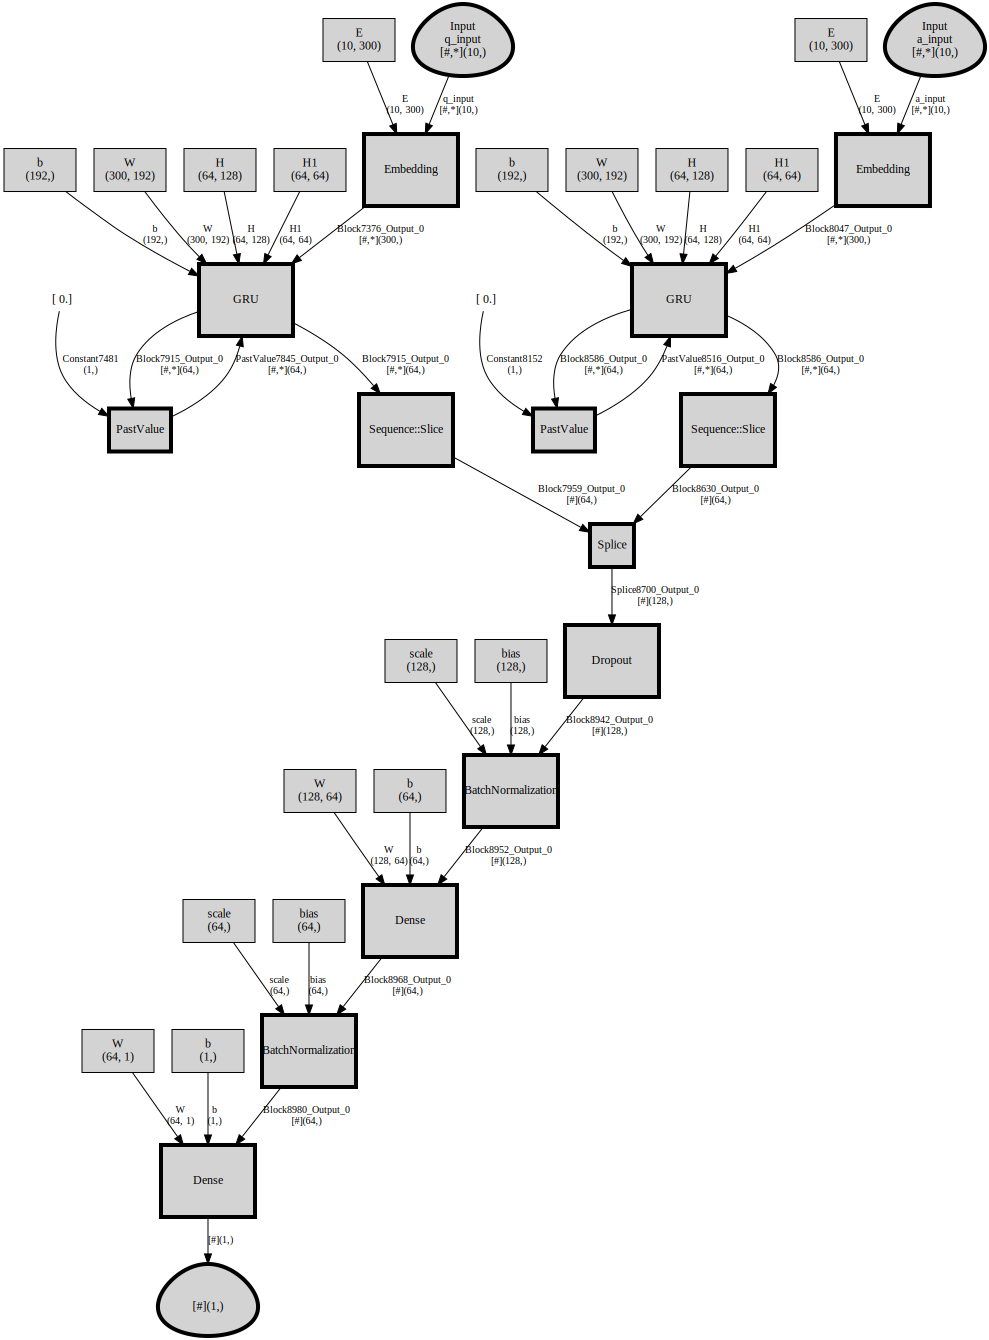

In [9]:
from IPython.display import SVG, display

def display_model(model):
    svg = C.logging.graph.plot(model, "tmp.svg")
    display(SVG(filename="tmp.svg"))

display_model(model_layers_distinct_axes)

Let's fix this by sharing the embedding. Sharing the GRU parameters can be done in an even simpler way as shown in the unused function `create_model_shared_all`. In the layers library, passing an input to a layer means sharing parameters with all other inputs that get passed to this layer. If you need a copy of the parameters you need to explicitly make one either via `clone()` or by creating a new layer object. 

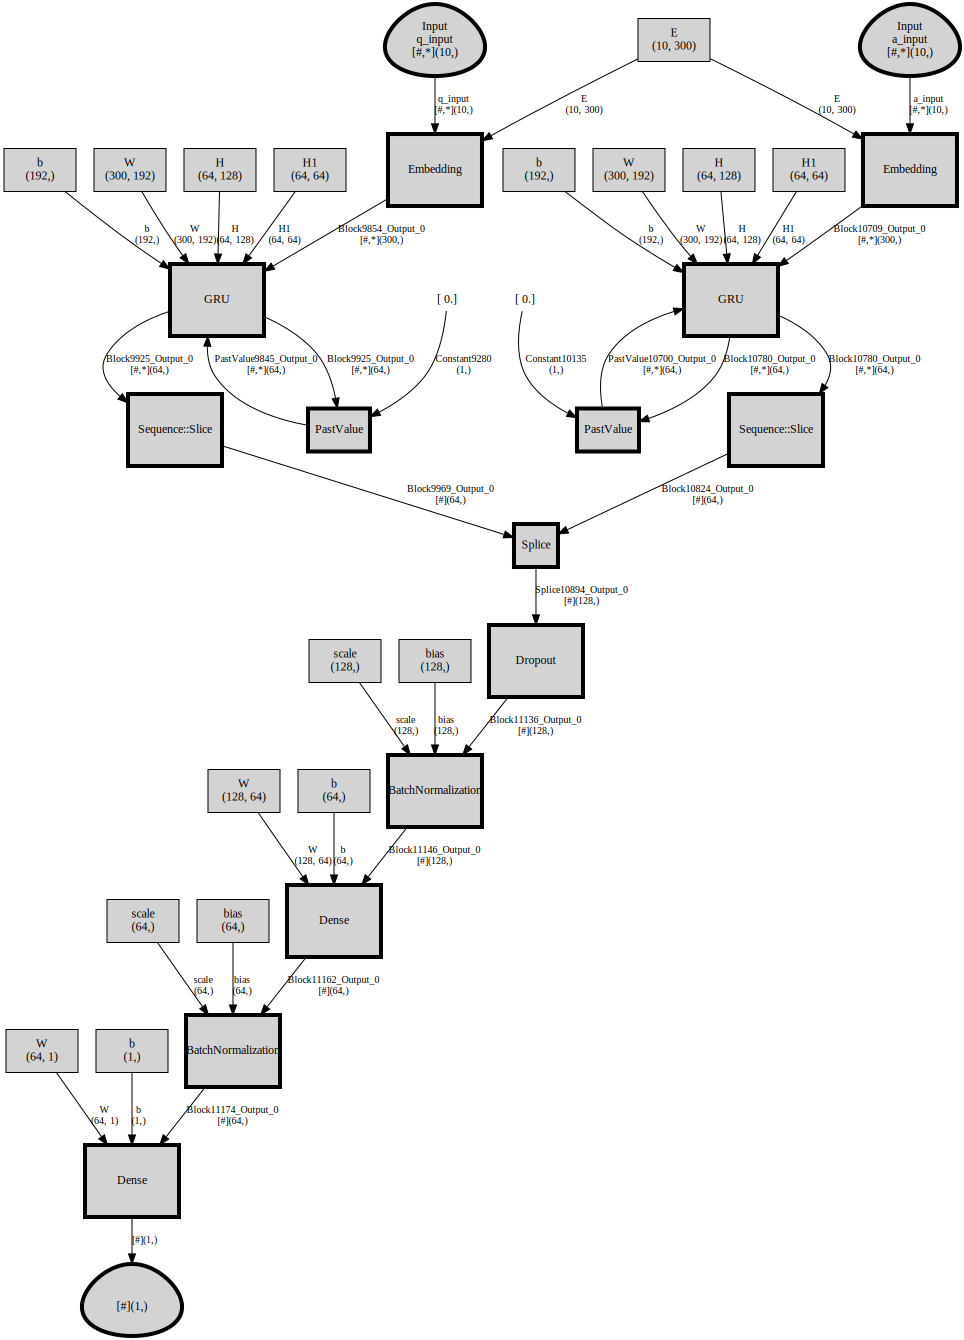

In [10]:
def create_model_shared_embedding(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        e = C.layers.Embedding(300)
        question_stack = C.layers.Sequential([e, C.layers.Fold(C.layers.GRU(64))])(question_input)
        answer_stack = C.layers.Sequential([e, C.layers.Fold(C.layers.GRU(64))])(answer_input)
        combined = C.splice(question_stack, answer_stack)
        model = C.layers.Sequential([C.layers.Dropout(0.5),
                               C.layers.BatchNormalization(),
                               C.layers.Dense(64, activation=C.sigmoid),
                               C.layers.BatchNormalization(),
                               C.layers.Dense(1, activation=C.softmax)])
        return model(combined)

def create_model_shared_all(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        stack = C.layers.Sequential([C.layers.Embedding(300), C.layers.Fold(C.layers.GRU(64))])
        question_stack = stack(question_input)
        answer_stack = stack(answer_input)
        combined = C.splice(question_stack, answer_stack)
        model = C.layers.Sequential([cl.Dropout(0.5),
                               C.layers.BatchNormalization(),
                               C.layers.Dense(64, activation=C.sigmoid),
                               C.layers.BatchNormalization(),
                               C.layers.Dense(1, activation=C.softmax)])
        return model(combined)

model_shared_embedding = create_model_shared_embedding(q_input, a_input)

display_model(model_shared_embedding)

### Guideline 4

> Verify weight sharing and other structural issues in your network by plotting the underlying graph

We are much better at processing visual information than by following the equations of a big model. With CNTK only the necessary dimensions need to be specified and everything else can be inferred. However when we plot a graph we can see the shapes of all inputs, outputs, and parameters at the same time, without having to do the shape inference in our heads.  

### More model bugs

Once all the structural bugs have been eliminated we can proceed in finding bugs related to running data through the network. We can start with feeding random data but a better choice is to feed the first few minibatches of real data through the network. This can reveal scale issues i.e. that the output or some other intermediate layer can take on too large values. 

A common cause of this is that the **learning rate is too high**. This will be observed from the second minibatch onwards and it can cause the learning to diverge. If you see large values in parameters or other outputs, just reduce the learning rate by a factor of 2 and retry until things look stable. 

Another possibility can be that the **data contains large values** which can cause intermediate outputs to become large and even overflow if the network is doing a lot of processing (such as an RNN on a long sequence or a very deep network). The training procedures currently used actually work better when the input values do not contain outliers and are centered or close to 0 (this is the reason why in many examples with image data you can see that the first thing that happens is the subtraction of the average pixel value). If you have large values in the input you can try dividing the data by the maximum value. If you have non-negative values and you want to mostly preserve the order of magnitude but don't care so much about the exact value you can transform your inputs with a `log` i.e. `transformed_features = C.log(1+features)`.

In our sample code we have a problem that could be detected simply by feeding random data so we will do just that:

In [11]:
random_questions = [sparse.rand(i*i+1, 10, density=0.5, format='csr', dtype=np.float32) for i in range(5)]
random_answers = [sparse.rand(i+1, 10, density=0.5, format='csr', dtype=np.float32) for i in range(5)] 

model_shared_embedding.eval({q_input:random_questions, a_input:random_answers})

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

This is very suspicious. We gave 5 **random** "questions" (of lengths 1, 2, 5, 10, and 17), and 5 **random** "answers" (of lengths 1, 2, 3, 4, and 5) and we got the **same** response. Again we can perform a binary search through the network to see where the responses become so uniform.  We find that the following network behaves as expected

In [12]:
def create_model_shared_embedding_working(question_input, answer_input):
    with C.default_options(init=C.glorot_uniform()):
        e = C.layers.Embedding(300)
        question_stack = C.layers.Sequential([e, C.layers.Fold(C.layers.GRU(64))])(question_input)
        answer_stack = C.layers.Sequential([e, C.layers.Fold(C.layers.GRU(64))])(answer_input)
        combined = C.splice(question_stack, answer_stack)
        model = C.layers.Sequential([C.layers.Dropout(0.5),
                               C.layers.BatchNormalization(),
                               C.layers.Dense(64, activation=C.sigmoid),
                               C.layers.BatchNormalization()])
        return model(combined)

model_shared_embedding_working = create_model_shared_embedding_working(q_input, a_input)

working_outputs = model_shared_embedding_working.eval({q_input:random_questions, a_input:random_answers})
print(working_outputs[:,:3])

[[  3.16227753e+02   2.50644880e-05   3.16227753e+02]
 [  3.16226990e+02   2.93088074e+02   3.16227722e+02]
 [  3.16227753e+02   3.17077647e-05   3.16227753e+02]
 [  3.16227753e+02   2.67724752e-01   3.16227753e+02]
 [  3.16227753e+02   2.03854484e-06   3.16211945e+02]]


The only difference then is this line
```python
cl.Dense(1, activation=C.softmax)
```
We can play around a little more e.g. by modifying the activation or the number of outputs and we find that everything is working except for the combination of arguments given above. If we look at the definition of softmax we can see the problem:
$$
\textrm{softmax}(z) = \left(\begin{array}{c} \frac{\exp(z_1)}{\sum_j \exp(z_j)}\\ \frac{\exp(z_2)}{\sum_j \exp(z_j)}\\ \vdots \\ \frac{\exp(z_n)}{\sum_j \exp(z_j)} \end{array}\right)
$$
and we only have one output! So the softmax will compute the exponential of that output and then **divide it by itself** giving us 1. One solution here is to have two outputs, one for each class. This is different from how binary classification is typically done where there's a single output representing the probability of the positive class. This latter approach can be implemented by using a sigmoid non-linearity. Therefore either of the following will work:
```python
cl.Dense(1, activation=C.sigmoid)
```
or
```python
cl.Dense(2, activation=C.softmax)
```

### Guideline 5

> Feed some data to your network and look for large values in the output or other suspicious behavior.

It's also good if you can train for a few minibatches to see if different outputs in the network exhibit worrisome trends, which could mean that your learning rate is very large.


### Tricky errors

Even after you have tried all of the above, you might still ran into problems. One example is a `NaN` (Not-a-Number) which you can get from operations whose meaning is not defined (for example $0 \times \infty$ or ${(-0.5)}^{0.5}$). Another case is if you are writing your own layer and it is not behaving as expected. CNTK offers some support to find your issue. Here's a contrived example that demonstrates how to catch where `NaN`s are generated.

In [13]:
C.debugging.set_checked_mode(False)
w = C.input_variable(1)
x = C.input_variable(1)
y = C.layers.Sequential([C.square, C.square, C.square])
z = C.exp(-y(x))*C.exp(y(w))+1

w0 = np.array([3.0],dtype=np.float32)
x0 = np.array([3.0],dtype=np.float32)
z.eval({w:w0, x:x0})

array([[ nan]], dtype=float32)

The code computes $3^8=6561$ and then takes the exponetial of it (which overflows to infinity) and the expoential of it's negative (which underflows to 0). The result above is because $0 \times \infty$ is `NaN` according to the floating point standard. If we understand the issue like in this contrived example we can rearrange our computations for example as 

In [14]:
z_stable = C.exp(-y(x)+y(w))+1

w0 = np.array([3.0],dtype=np.float32)
x0 = np.array([3.0],dtype=np.float32)
z_stable.eval({w:w0, x:x0})

array([[ 2.]], dtype=float32)

Typically we don't know what causes the `NaN` to get generated. CNTK provides a "checked mode" where `NaN`s can cause an exception. The request for checked_mode needs to be specified before the function is created.

In [15]:
C.debugging.set_checked_mode(True)
z.eval({w:w0, x:x0})

array([[ nan]], dtype=float32)

Error: ElementTimes13775 ElementTimes operation unexpectedly produced NaN values.


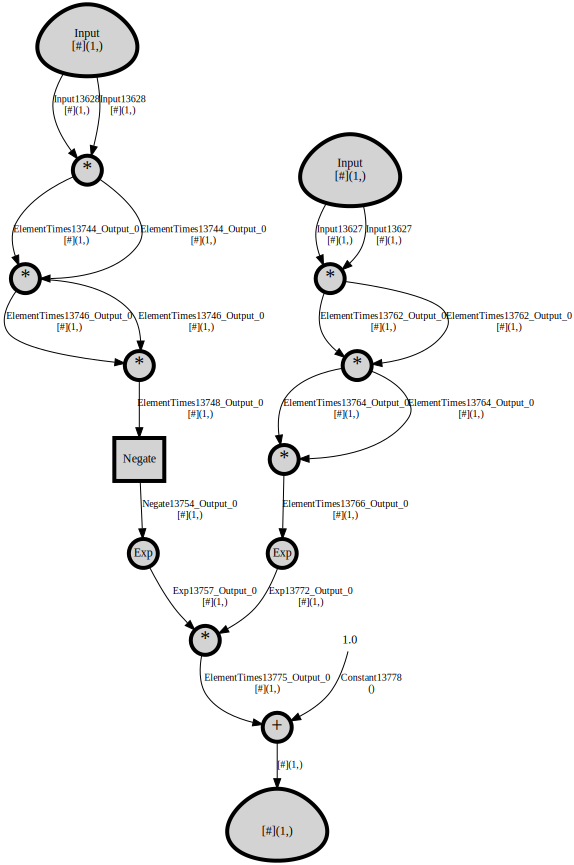

In [16]:
C.debugging.set_checked_mode(True)
z_checked = C.exp(-y(x))*C.exp(y(w))+1
try:
    z_checked.eval({w:w0, x:x0})
except:
    exc_type, exc_value, exc_traceback = sys.exc_info()
    error_msg = str(exc_value).split('\n')[0]
    print("Error: %s"%error_msg)
display_model(z_checked)

Searching for the name of the operation in the graph, we (unsurprisingly) find that it is the multiplication of the two exponentials that is causing the issue (The number after ElementTimes matches the output name of that node in the graph).

### Guideline 6

> Use `set_checked_mode(True)` to figure out which operation is producing NaNs

This was a contrived example, and in some cases you can get NaNs after many hours of training. Checked mode is introducing a big performance hit so you will need to rerun from your last valid checkpoint. While that is happening on the background inspect your graph for operations that can cause problems such as exponentials that can produce very large numbers.

Finally, the debugging module includes two other ways that can help you find problems with your code

* The `set_computation_network_trace_level()` function takes an integer argument that determines the amount of information that CNTK will produce for each operation in the graph
 - 1: outputs the dimensions and some other static information
 - 1000: outputs for each minibatch the sum of absolute values of all the elements in the output (this can help catch sign and permutation errors) 
 - 1000000: outputs for each minibatch all the elements in the output. This is intended to be used as a last resort.
* The `debug_model()` function takes a CNTK network and returns a new network that has debug operations inserted everywhere. Debug operations can let you inspect the values that flow through the network in the forward and backward direction in an interactive way in the console. This is hard to appeciate through this tutorial, since if we were to run this here it would freeze this notebook (waiting for user input), but you are welcome to check out the [documentation](https://www.cntk.ai/pythondocs/cntk.debugging.debug.html) of how it works and try it out!

### Guideline 7

> Use `debug_model(function)` and `set_computation_network_trace_level(level)` to smoke out any remaining bugs. 


### Very advanced bugs

Beyond the debugging module, there are a few more internal APIs that can help with certain classes of bugs. All of these internal APIs are in the `cntk.cntk_py` module so when we refer to, say, `force_deterministic_algorithms()` that really means
`cntk_py.force_deterministic_algorithms()`. The following functions can be useful
- **`force_deterministic_algorithms()`**: Many of the libraries we use offer various algorithms for performing each operation. Typically the fastest algorithms are non-deterministic because the output is a summation (as in the case of matrix products or convolutions) and multiple threads are working on partial sums that have to be added together. Since addition of floating point numbers is not associative, you can get different results from different executions. force_deterministic_algorithms() will make all subsequent operations select a slower but deterministic algorithm if one is available. This is useful when bitwise reproducibility is important.
- **`set_gpumemory_allocation_trace_level(level)`**: Sets the trace level for gpu memory allocations. A value greater than 0 will cause the gpu memory allocator to print information about the allocation, the free and total memory, and a call stack of where this allocation was called  from. This can be useful in debugging out of memory issues on the GPU.
- **`enable_synchronous_gpukernel_execution()`**: Makes all gpu kernel launches synchronous. This can help with profiling execution times because the profile of a program with asynchronous execution of gpu kernels can be hard to interpret.
- **`set_fixed_random_seed(value)`**: All CNTK 2.0 code goes through a single GenerateRandomSeed API which by default assigns distinct random seeds to each operation that requires randomness (including, random initialization, dropout, and random number generation according to a distribution). With this call all these operations will have the same fixed random seed which can help debug reproducibility issues after you have refactored your program and some parts of the networks are now created in different order. There is still some legacy code that picks the random seed in other ways, so you can still get non-reproducible results with this option. Furthermore, this option reduces the statistical quality of dropout and other random operations in the network and should be used with care.
- **`disable_forward_values_sharing()`**: CNTK is very aggressive about reusing GPU memory. There are many opportunities both during the forward and the backward pass where a buffer of intermediate results can be reused. Unfortunately, if you write a new operation and do not properly mark which buffers should and should not be reused, you can have very subtle bugs. The backward value sharing is straightforward and you cannot do much to cause CNTK to get it wrong. If you are suspecting such a bug you can see whether disabling forward values (buffers) sharing leads to different results. If so, you need to investigate whether your operation is improperly marking some buffers as possible to share.


### Guideline 8

> Use `cntk_py.set_gpumemory_allocation_trace_level(1)` to find out why you are running out of GPU memory.

### Guideline 9

> Use `cntk_py.enable_synchronous_gpukernel_execution()` to make the profiling results easier to understand.

### Guideline 10

> Use `cntk_py.force_deterministic_algorithms()` and `cntk_py.set_fixed_random_seed(seed)` to improve reproducibility.

### Guideline 11

> Use `cntk_py.disable_forward_values_sharing()` if you suspect a memory sharing issue with CNTK.

In [17]:
# For testing purposes, ensure that what the guide says can be executed without failures
C.debugging.set_computation_network_trace_level(1)
C.cntk_py.set_gpumemory_allocation_trace_level(1)
C.cntk_py.enable_synchronous_gpukernel_execution()
C.cntk_py.force_deterministic_algorithms() 
C.cntk_py.set_fixed_random_seed(98052)
C.cntk_py.disable_forward_values_sharing()
dm = C.debugging.debug_model(model_shared_embedding_working) 